# Extracellular Electrophysiology Session

At the Allen Institute for Brain Science we carry out in vivo extracellular electrophysiology (ecephys) experiments  in awake animals using high-density Neuropixels probes. The data from these experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- LFP data
- behavioral data, such as running speed and eye position
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The `EcephysSession` class in `allensdk.brain_observatory.ecephys.ecephys_session` provides an interface to all of the data for a single session, aligned to a common clock. This notebook will show you how to use the `EcephysSession` class to extract these data.

Contents
* <a href='#Obtaining-an-EcephysSession'>Obtaining an EcephysSession</a>
* <a href='#Stimulus-presentations'>Stimulus information</a>
* <a href='#Spike-data'>Spike data</a>
* <a href='#Waveforms'>Unitwise mean waveforms</a>

In [1]:
# first we need a bit of import boilerplate

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession, removed_unused_stimulus_presentation_columns
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts
from allensdk.brain_observatory.visualization import plot_running_speed

### Obtaining an `EcephysSession`

We package each session's data into a Neurodata Without Borders (NWB) file. If you have such a file on your hard drive, you can build an `EcephysSession` object for accessing the data within that file. The `EcephysSession` will load data from the file on demand and cache it in memory.

In [2]:
# TODO: this path ought not to point locally
nwb_path = '/allen/scratch/aibstemp/nileg/ecephys_session_777171782.nwb'
session = EcephysSession.from_nwb_path(nwb_path)

We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [3]:
session.units.head()

,firing_rate,isi_violations,peak_channel_id,snr,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,location
unit_id,,,,,,,,,
812334936,1.547713,0.474057,812334250,1.618947,27,792623853,440,probeA,
812334940,5.301020,0.151586,812334322,1.270418,27,792623853,800,probeA,
812334946,5.660441,0.570943,812334334,0.672529,11,792623853,860,probeA,
812334948,5.659988,0.655994,812334338,0.864576,27,792623853,880,probeA,
812334950,12.268877,0.586666,812334344,1.867299,59,792623853,920,probeA,


As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [4]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total')
units_with_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_high_snr.shape[0]} units have snr > 4')

796 units total
74 units have snr > 4


... as well as some more advanced (and very useful!) operations. For more information, please see the pandas documentation. The following topics might be particularly handy:

- [selecting data](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
- [merging multiple dataframes](http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
- [grouping rows within a dataframe](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)
- [pivot tables](http://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)

### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*. Usually these correspond to a single 60hz frame on the monitor, but there are a couple of exceptions to this rule:
1. Gray screen periods are used to collect baseline data. Each such period is considered a single presentation.
2. Occasionally the monitor refresh and frame buffer flip alias over one another, causing the monitor to refresh before it is flipped. This causes the currently displayed stimulus to be displayed for two frames rather than one (after this, regular presentation resumes).

You can find information about the stimulus presentations that were presented during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [23]:
session.stimulus_presentations.head()

,start_time,stop_time,stimulus_name,stimulus_block,TF,SF,Ori,Contrast,Pos_x,Pos_y,Color,Image,Speed,Dir,is_movie
stimulus_presentation_id,,,,,,,,,,,,,,,
0,15.060243,75.127029,gray_period,null,null,null,null,null,null,null,null,null,null,null,False
1,75.127029,75.360550,gabor_20_deg_250ms,0,4,0.08,90,0.8,40,20,null,null,null,null,False
2,75.360550,75.610748,gabor_20_deg_250ms,0,4,0.08,45,0.8,-10,-30,null,null,null,null,False
3,75.610748,75.860939,gabor_20_deg_250ms,0,4,0.08,45,0.8,10,-30,null,null,null,null,False
4,75.860939,76.111137,gabor_20_deg_250ms,0,4,0.08,0,0.8,20,10,null,null,null,null,False


Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- is_movie : Some stimuli (usually with names like "natural_movie_{name}" actually consist of a temporally coherent video clip. Since users of the data might want to analyze these stimuli differently than the others, the is_movie column flags each presentation as belonging to a multi-frame movie or not.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [6]:
session.stimulus_presentations['stimulus_name'].unique().tolist()

['gray_period',
 'gabor_20_deg_250ms',
 'flash_250ms',
 'contrast_response',
 'natural_movie_1_more_repeats',
 'natural_movie_shuffled',
 'drifting_gratings_more_repeats',
 'motion_stimulus']

We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those paremeters:

In [7]:
session.get_stimulus_parameter_values()

{'TF': array(['null', 4.0, 2.0], dtype=object),
 'SF': array(['null', 0.08, 0.04], dtype=object),
 'Ori': array(['null', 90.0, 45.0, 0.0, 135.0], dtype=object),
 'Contrast': array(['null', 0.8, 0.6, 0.08, 0.13, 0.01, 0.2, 0.04, 0.35, 1.0, 0.02,
        0.1], dtype=object),
 'Pos_x': array(['null', 40.0, -10.0, 10.0, 20.0, -40.0, -30.0, 0.0, -20.0, 30.0],
       dtype=object),
 'Pos_y': array(['null', 20.0, -30.0, 10.0, 0.0, 30.0, -20.0, -10.0, -40.0, 40.0],
       dtype=object),
 'Color': array(['null', 1.0, -1.0], dtype=object),
 'Image': array(['null', 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
        11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
        22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0,
        33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0,
        44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0,
        55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0,
        66.0,

What if we want parameter values for just one kind of stimulus, "drifting_gratings_more_repeats" for instance? Let's check the help for `get_stimulus_parameter_values`:

In [8]:
help(session.get_stimulus_parameter_values)

Help on method get_stimulus_parameter_values in module allensdk.brain_observatory.ecephys.ecephys_session:

get_stimulus_parameter_values(stimulus_presentation_ids=None) method of allensdk.brain_observatory.ecephys.ecephys_session.EcephysSession instance
    For each stimulus parameter, report the unique values taken on by that 
    parameter throughout the course of the  session.
    
    Parameters
    ----------
    stimulus_presentation_ids : array-like, optional
        If provided, only parameter values from these stimulus presentations will be considered.
    
    Returns
    -------
    dict : 
        maps parameters (column names) to their unique values.



From this help message we can see that `get_stimulus_parameter_values` takes an optional filtering parameter - an array of stimulus presentation ids. If we first find all of the stimulus presentations where drifting gratings were presented and then supply their ids to `get_stimulus_parameter_values`, we can find out what parameter values were used for drifting gratings in this session:

In [9]:
drifting_gratings_presentations = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'drifting_gratings_more_repeats'
]
# the ".index.values" takes a dataframe  of presentations and returns a numpy array of presentation ids
drifting_gratings_presentation_ids = drifting_gratings_presentations.index.values 
session.get_stimulus_parameter_values(stimulus_presentation_ids=drifting_gratings_presentation_ids)

{'TF': array([2.0], dtype=object),
 'SF': array([0.04], dtype=object),
 'Ori': array([135.0, 90.0, 0.0, 45.0], dtype=object),
 'Contrast': array([0.8, 0.1], dtype=object)}

It is not necessarily true that all possible parameter value combinations were presented. We can enumerate the combinations that were presented by calling `get_stimulus_conditions`. As with `get_stimulus_parameter_values` we can filter on stimulus presentation ids.

In [10]:
session.get_stimulus_conditions(stimulus_presentation_ids=drifting_gratings_presentation_ids).head()

,stimulus_name,TF,SF,Ori,Contrast
0,drifting_gratings_more_repeats,2,0.04,135,0.8
1,drifting_gratings_more_repeats,2,0.04,90,0.1
2,drifting_gratings_more_repeats,2,0.04,0,0.1
3,drifting_gratings_more_repeats,2,0.04,45,0.8
4,drifting_gratings_more_repeats,2,0.04,45,0.1


### Spike data

The `EcephysSession` object holds spike times (in seconds) for each unit. These are stored in a dictionary, which maps unit ids to arrays of spike times.

In [11]:
unit_id = 812329530 # for example
print(f'{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id}')
session.spike_times[unit_id]

1955 spikes were detected for unit 812329530


array([8420.55566471, 9050.97631648, 5688.25052993, ..., 8624.16186922,
       5480.23706514, 8106.84335331])

It is commonly useful to compare spike data from across units and stimulus presentations, all relative to the onset of a stimulus presentation. We can do this using the `presentationwise_spike_counts` method. 

In [12]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 300)

# look at responses to the flash stimulus ...
flash_250_ms_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flash_250ms'
].index.values

# ... and only for units that have relatively good signal to noise ratios
good_unit_ids = session.units[session.units['snr'] > 1].index.values

ds = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=good_unit_ids
)
ds

<xarray.Dataset>
Dimensions:                          (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 299, unit_id: 603)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.009314 ... 0.3993
  * unit_id                          (unit_id) int64 812334936 ... 812329528
Data variables:
    spike_counts                     (stimulus_presentation_id, time_relative_to_stimulus_onset, unit_id) uint16 0 ... 0

This has returned a new (to this notebook) data structure, the `xarray.DataSet`. You can think of this as similar to a 3+D `pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Data variables : One or more (in our case one) multidimensional arrays of data, similar to `numpy.ndarray`s. We can access our data array of spike times like: `ds['spike_counts']`.
- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

We can now plot spike counts for a particular presentation:

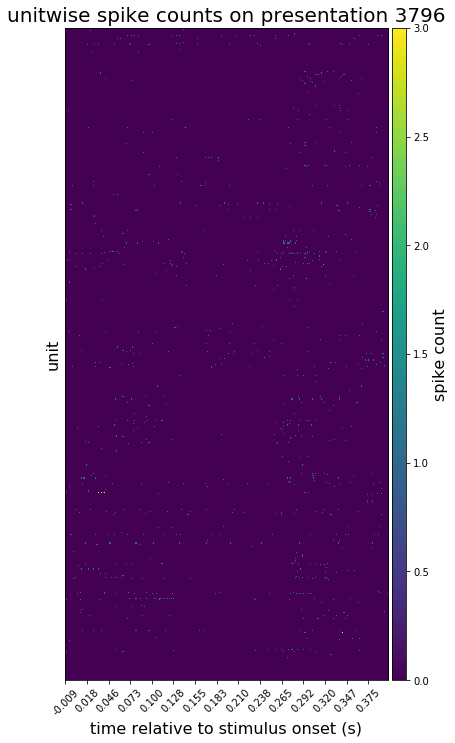

In [13]:
presentation_id = 3796
plot_spike_counts(
    ds['spike_counts'].loc[{'stimulus_presentation_id': presentation_id}], 
    ds['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a stimulus_presentation_id dimension, as we have collapsed it by averaging.

In [14]:
ds['mean_spike_counts'] = ds['spike_counts'].mean(dim='stimulus_presentation_id')
ds

<xarray.Dataset>
Dimensions:                          (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 299, unit_id: 603)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.009314 ... 0.3993
  * unit_id                          (unit_id) int64 812334936 ... 812329528
Data variables:
    spike_counts                     (stimulus_presentation_id, time_relative_to_stimulus_onset, unit_id) uint16 0 ... 0
    mean_spike_counts                (time_relative_to_stimulus_onset, unit_id) float64 0.0 ... 0.0

... and plot the mean spike counts

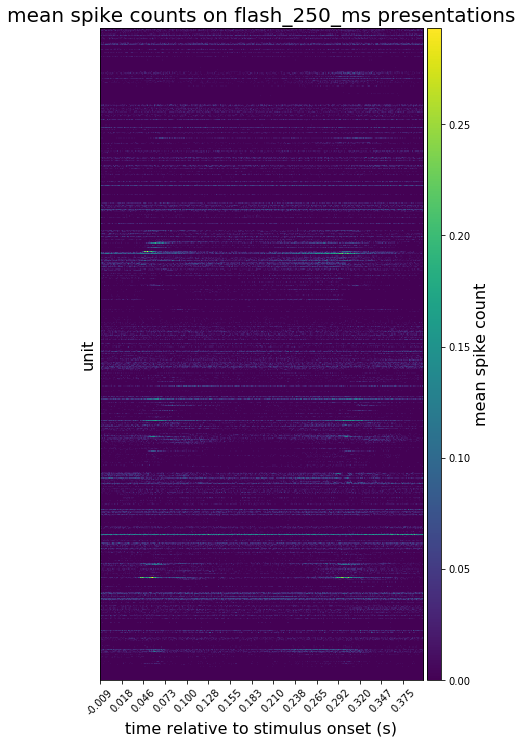

In [15]:
plot_spike_counts(
    ds['mean_spike_counts'], 
    ds['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations'
)
plt.show()

As a control, it can be useful to obtain spike counts that are not aligned to stimulus onset. We can do that by providing the `time_domain_callback` parameter to `presentationwise_spike_counts`. This parameter takes in a function, which maps a 2D numpy ndarray to another 2D numpy ndarray of the same shape. The dimension of this array are trials X bins edges.

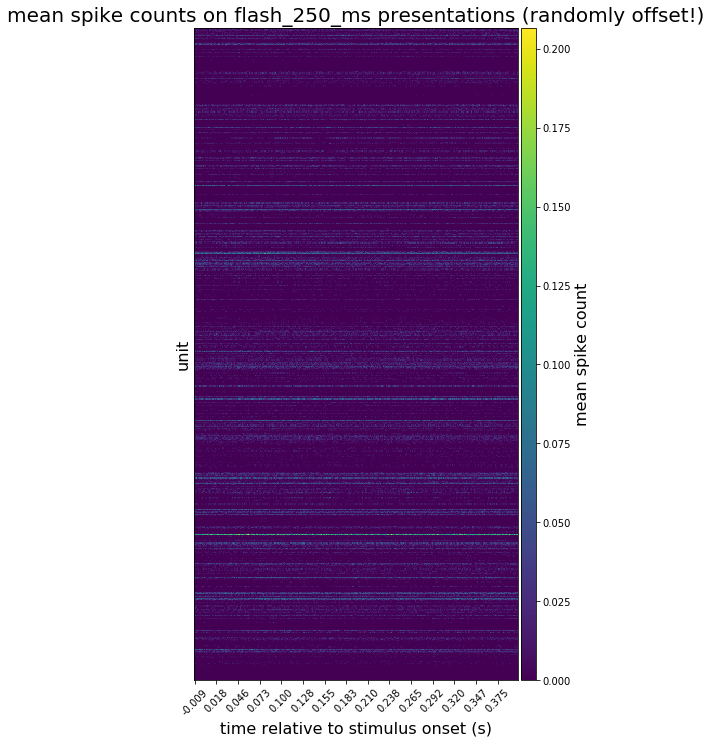

In [16]:
def random_offset(arr):
    # each row of arr are the bin edges we specified above, aligned to the trials we selected
    # this function adds a random translation of [-0.25, 0.25] seconds to each row
    offsets = (np.random.rand((arr.shape[0])) - 0.5) / 2
    return arr + offsets[:, None]
    
randomized_ds = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=good_unit_ids,
    time_domain_callback=random_offset
)
randomized_ds['mean_spike_counts'] = randomized_ds['spike_counts'].mean(dim='stimulus_presentation_id')
plot_spike_counts(
    randomized_ds['mean_spike_counts'], 
    ds['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations (randomly offset!)'
)
plt.show()

##### Ragged spike data

We saw above how to build spike histograms, but what if we want to associate spikes with stimulus presentations while still preserving their specific event times? We can do this using `presentationwise_spike_times`, which returns a dataframe of spike times, tagged with their unit and stimulus presentation ids:

In [17]:
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings_more_repeats')
    & (session.stimulus_presentations['Ori'] == 90)
].index.values

good_probea_unit_ids = session.units.loc[
    (session.units['snr'] > 2)
    & (session.units['probe_description'] == 'probeA')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=good_probea_unit_ids
)

times.head()

,stimulus_presentation_id,unit_id
spike_time,,
3508.779998,40342,812334964
3507.628164,40342,812334964
3520.855277,40346,812334964
3529.667120,40349,812334964
3541.342199,40353,812334964


What if we want to know how many spikes a given stimulus condition evoked? We can call `conditionwise_spike_counts` on our session object

In [18]:
contrast_response_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'].isin(set(['contrast_response']))
].index.values

contrast_response_probea_spike_counts = session.conditionwise_spike_counts(
    unit_ids=good_probea_unit_ids, 
    stimulus_presentation_ids=contrast_response_presentation_ids
)

# filter out inapplicable stimulus columns for cleaner display
contrast_response_probea_spike_counts = removed_unused_stimulus_presentation_columns(contrast_response_probea_spike_counts)
contrast_response_probea_spike_counts.head()

,unit_id,stimulus_name,TF,SF,Ori,Contrast,count
0,812334964,contrast_response,2.0,0.04,0.0,0.01,8
1,812334964,contrast_response,2.0,0.04,0.0,0.02,5
2,812334964,contrast_response,2.0,0.04,0.0,0.04,15
3,812334964,contrast_response,2.0,0.04,0.0,0.08,25
4,812334964,contrast_response,2.0,0.04,0.0,0.13,11


We can also get mean spike counts per stimulus condition:

In [19]:
mean_spike_counts = session.conditionwise_mean_spike_counts(
    unit_ids=good_probea_unit_ids, 
    stimulus_presentation_ids=contrast_response_presentation_ids
)
mean_spike_counts = removed_unused_stimulus_presentation_columns(mean_spike_counts)
mean_spike_counts.head()

,unit_id,stimulus_name,TF,SF,Ori,Contrast,mean_spike_count
0,812334964,contrast_response,2.0,0.04,0.0,0.01,0.533333
1,812334964,contrast_response,2.0,0.04,0.0,0.02,0.333333
2,812334964,contrast_response,2.0,0.04,0.0,0.04,1.000000
3,812334964,contrast_response,2.0,0.04,0.0,0.08,1.666667
4,812334964,contrast_response,2.0,0.04,0.0,0.13,0.733333


Using this mean spike counts dataframe, we can ask for each unit: which stimulus condition evoked the most activity on average?

In [20]:
max_rate_conditions = mean_spike_counts.groupby('unit_id')\
    .apply(lambda df: df.loc[df['mean_spike_count'].idxmax()])
max_rate_conditions.drop(columns='unit_id', inplace=True)
max_rate_conditions.head()

,stimulus_name,TF,SF,Ori,Contrast,mean_spike_count
unit_id,,,,,,
812334964,contrast_response,2.0,0.04,90.0,0.08,2.133333
812334976,contrast_response,2.0,0.04,45.0,0.04,0.066667
812334992,contrast_response,2.0,0.04,0.0,0.04,0.133333
812335016,contrast_response,2.0,0.04,90.0,0.20,1.600000
812335020,contrast_response,2.0,0.04,45.0,0.01,8.600000


### Waveforms

We store mean waveforms for each unit in the `mean_waveforms` attribute on the `EcephysSession` object. This is a dictionary which maps unit ids to 2D `numpy.ndarray`s. The row dimension of these arrays is channels, and the column dimension is time (seconds, aligned to the detected event times). The data values are millivolts, as measured at the recording site.

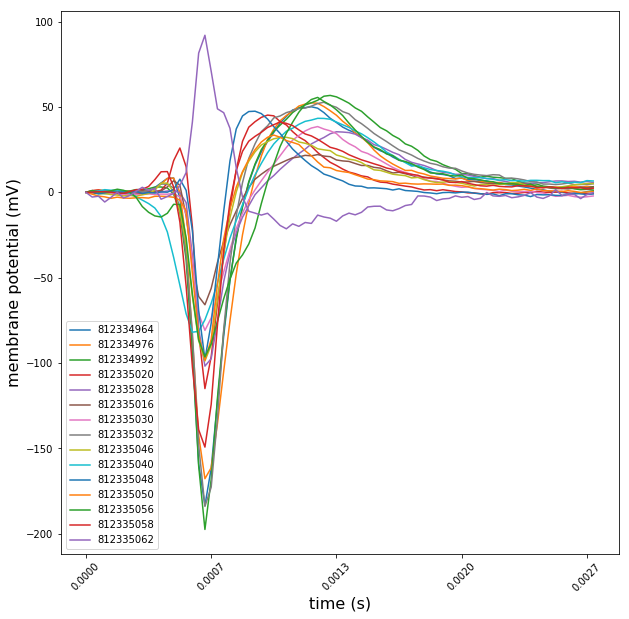

In [21]:
first_fifteen_units_waveforms = {uid: session.mean_waveforms[uid] for uid in good_probea_unit_ids[:15]}
plot_mean_waveforms(first_fifteen_units_waveforms, good_probea_unit_ids[:15])
plt.show()

### Running Speed

We can obtain the velocity at which the experimental subject ran as a function of time by accessing the `running_speed` attribute. This returns a [named tuple](https://docs.python.org/3/library/typing.html?#typing.NamedTuple) with two fields: timestamps and values. Timestamps report when on the session's master clock samples where taken, while values report the linear velocity (cm/s) of the subject at that time. Negative values indicate backwards running.

Here we'll plot the running speed trace for a single arbitrary stimulus presentation:

In [22]:
presentation_3807_rs_timestamp_indices = np.searchsorted(
    session.running_speed.timestamps,
    [
        session.stimulus_presentations.loc[3807, 'start_time'], 
        session.stimulus_presentations.loc[3807, 'stop_time']
    ]
)

plot_running_speed(
    session.running_speed.timestamps, 
    session.running_speed.values, 
    start_index=presentation_3807_rs_timestamp_indices[0],
    stop_index=presentation_3807_rs_timestamp_indices[1]
)
plt.show()

KeyError: 'running'